# Correction TP Time Series Analysis

Authors: Pavlo Mozharovskyi and François Roueff

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as ss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Settings

In [2]:
# Plot
plt.close('all')
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (15, 8)}
plt.rcParams.update(params)
# Seed initialization
np.random.seed(seed=1)
# For saving files
saving_activated = True # False

## Data set "Grippe"

### 1. Read the data and prepare them

Load the data

In [3]:
df = pd.read_csv('../data/Openhealth_S-Grippal.csv', delimiter=';', decimal=',')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 4 columns):
PERIODE                  1752 non-null object
IAS_brut                 1752 non-null float64
IAS_lisse                1752 non-null float64
Incidence_Sentinelles    1734 non-null float64
dtypes: float64(3), object(1)
memory usage: 54.8+ KB


,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


Change column names and time

In [4]:
df.columns = ['day', 'brut', 'lisse', 'incidence']
df.day = pd.to_datetime(df.day)
df.set_index('day', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1752 entries, 2009-07-01 to 2014-04-17
Data columns (total 3 columns):
brut         1752 non-null float64
lisse        1752 non-null float64
incidence    1734 non-null float64
dtypes: float64(3)
memory usage: 54.8 KB


,brut,lisse,incidence
day,,,
2009-07-01,1.7,2.2,2.3
2009-07-02,3.4,2.1,2.3
2009-07-03,2.1,2.1,2.3
2009-07-04,1.3,2.0,2.3
2009-07-05,14.2,2.0,2.3


Impute missing data

In [5]:
print('There are %d zero values for the variable "brut" to be interpolated.' % (df.brut == 0).sum())

There are 8 zero values for the variable "brut" to be interpolated.


In [6]:
ids = df.index[df.brut == 0]
for i in range(ids.shape[0]):
    ind = pd.date_range(ids[i], periods = 1, freq = 'D')
    df.brut[ind] = (float(df.brut[ind - 1]) + float(df.brut[ind + 1])) / 2.

### 2. Plot the data

Text(0.5,0,'Time')

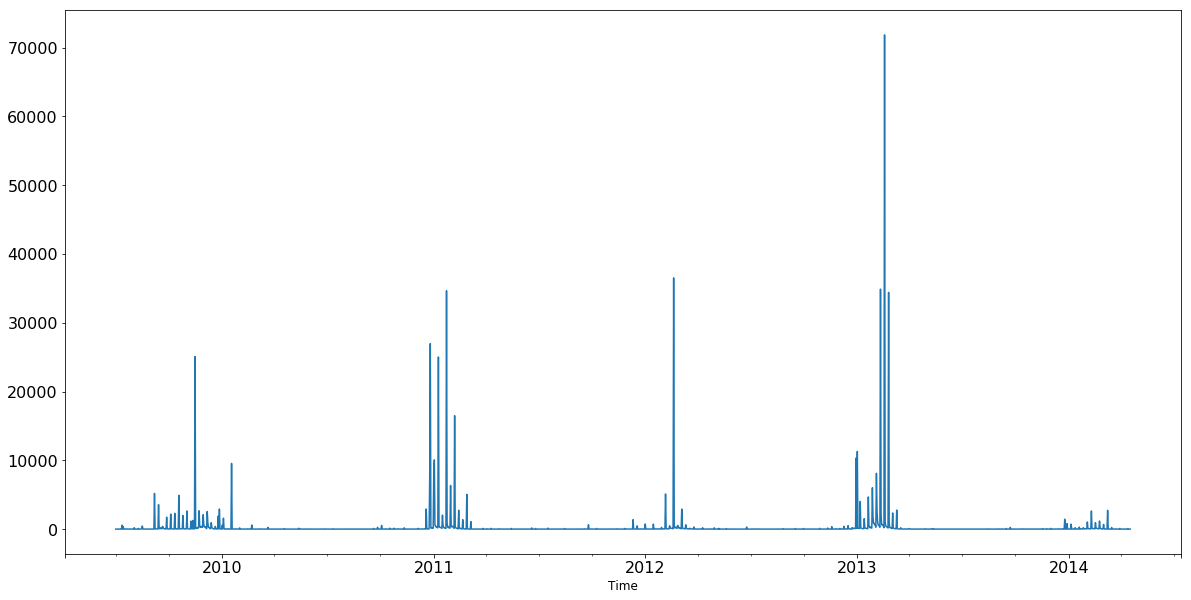

In [7]:
df.brut.plot(figsize=(20,10))
plt.xlabel('Time')

### 3. Plot the histogram of the marginal distribution

Text(0,0.5,'Frequency')

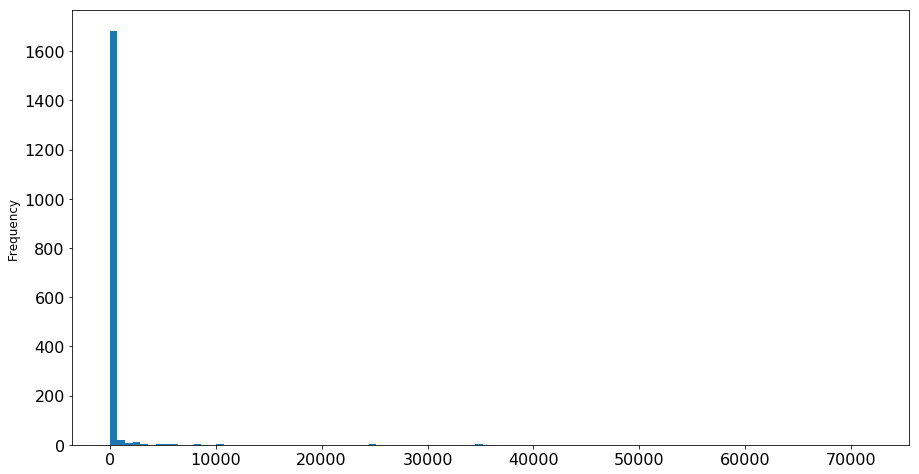

In [8]:
a = plt.hist(df.brut, 100)
plt.ylabel('Frequency')

### 4. Plot the data and the histogram for the logarithmized data

Text(0.5,0,'Time')

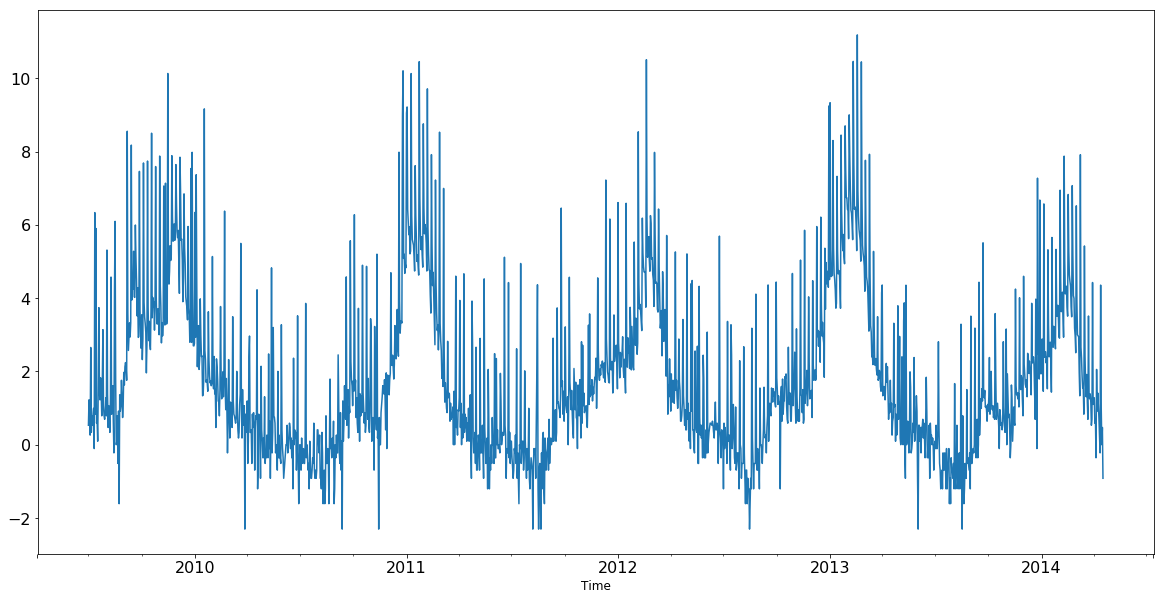

In [9]:
df['logbrut'] = np.log(df.brut)
df.head()
df.logbrut.plot(figsize=(20,10))
plt.xlabel('Time')

Text(0,0.5,'Frequency')

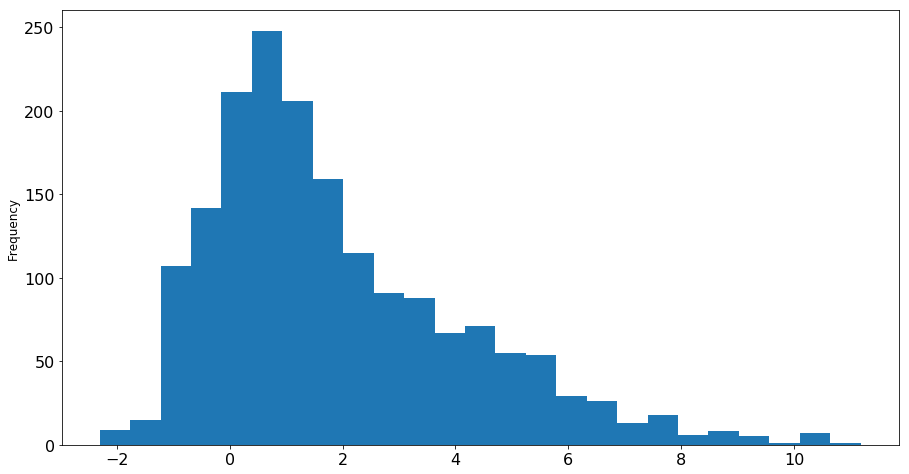

In [10]:
a = plt.hist(df.logbrut, 25)
plt.ylabel('Frequency')

### 5. Plot the spectrogram

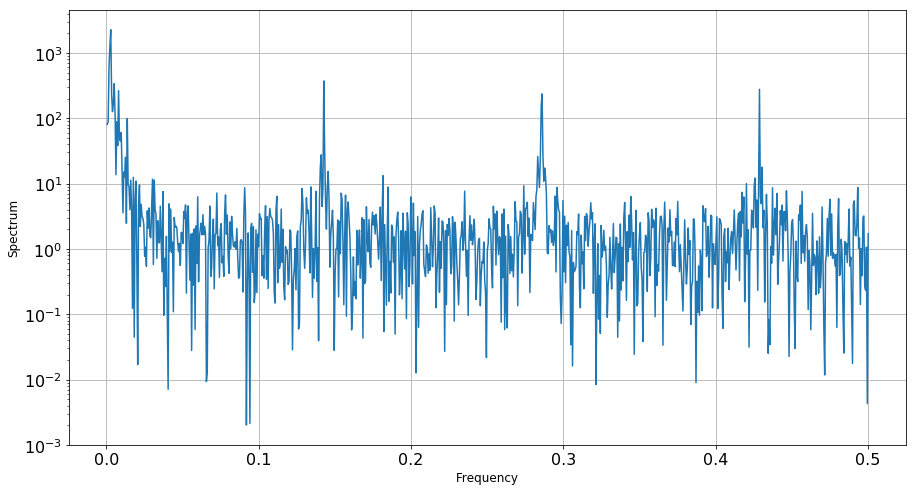

In [11]:
f, Pxx_den = signal.periodogram(df.logbrut)
plt.semilogy(f[1:], Pxx_den[1:])
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.show()

### 6. Plot 1-year lagged data (trend removal)

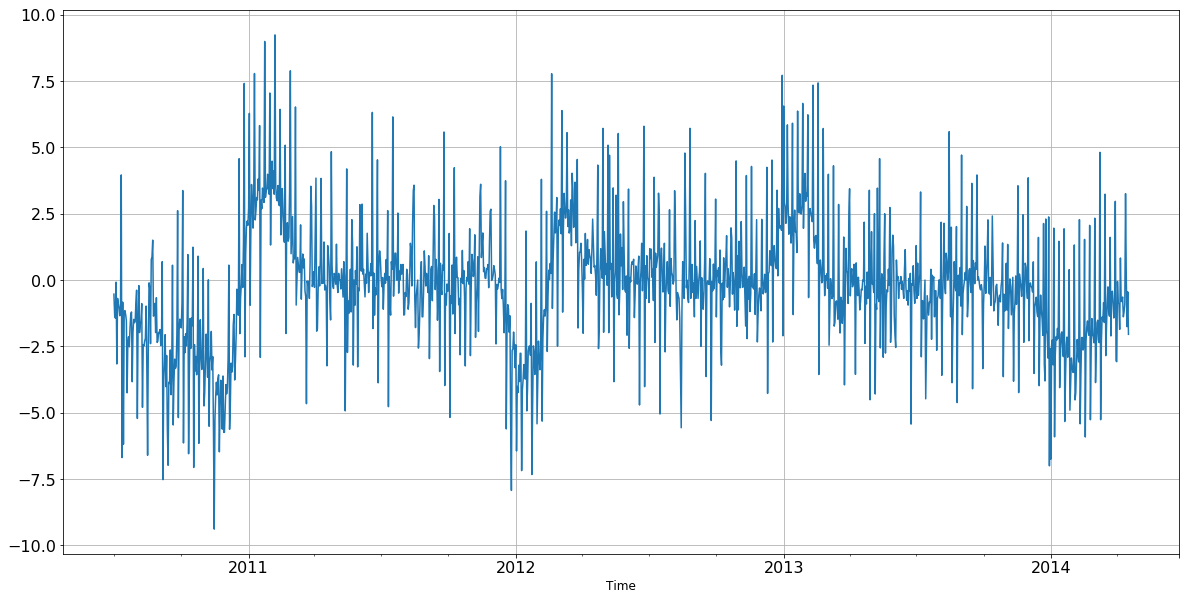

In [12]:
diffLogBrut = df.logbrut.diff(365)
diffLogBrut.plot(figsize=(20,10))
plt.xlabel('Time')
plt.grid()

And its periodogram

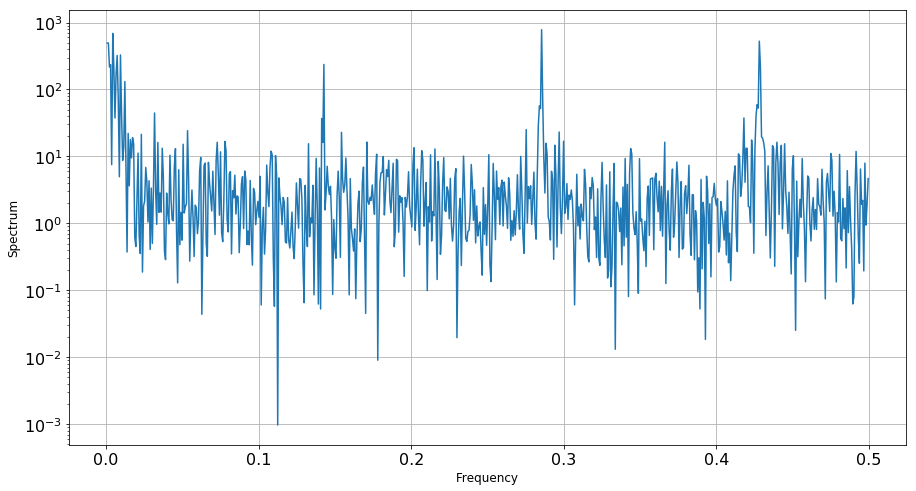

In [13]:
f_d, Pxx_den_d = signal.periodogram(diffLogBrut[365:])
plt.semilogy(f_d[1:], Pxx_den_d[1:])
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.show()

Compare densities of the one-year period 

In [14]:
Pxx_den[np.argmin(np.abs(f - 1 / 365))] - Pxx_den_d[np.argmin(np.abs(f_d - 1 / 365))]

2029.6897807952796

### 7. Deseasonalise and predict

Train and predict

In [15]:
# Define the number of sinusoids and the period
n_harms = 12 # vary this value
T = 365
# Create time indexing
tt = np.asarray(range(df.logbrut.count()), dtype=np.float64)
tt_train = tt[df.index < '2013-04-01']
tt_test = tt[df.index >= '2013-04-01']
# Create train and test data inluding the specified number of harmonics
X_train = pd.DataFrame()
X_test = pd.DataFrame()
for k in range(n_harms):
    X_train[str('cos' + str(k + 1))] = np.cos(tt_train * (k + 1) * 2 * np.pi / T)
    X_train[str('sin' + str(k + 1))] = np.sin(tt_train * (k + 1) * 2 * np.pi / T)
    X_test[str('cos' + str(k + 1))] = np.cos(tt_test * (k + 1) * 2 * np.pi / T)
    X_test[str('sin' + str(k + 1))] = np.sin(tt_test * (k + 1) * 2 * np.pi / T)
y_train = df.logbrut[df.index < '2013-04-01']
y_test = df.logbrut[df.index >= '2013-04-01']
# Train the model
pred_lin = LinearRegression().fit(X_train, y_train)
# Predict for the new data
y_old_pred = pred_lin.predict(X_train)
y_pred = pred_lin.predict(X_test)
y_errorSq = np.mean((y_pred - y_test) ** 2)
print("The prediction (squared) error = {:.4}".format(y_errorSq))

The prediction (squared) error = 1.866


Visualize prediction

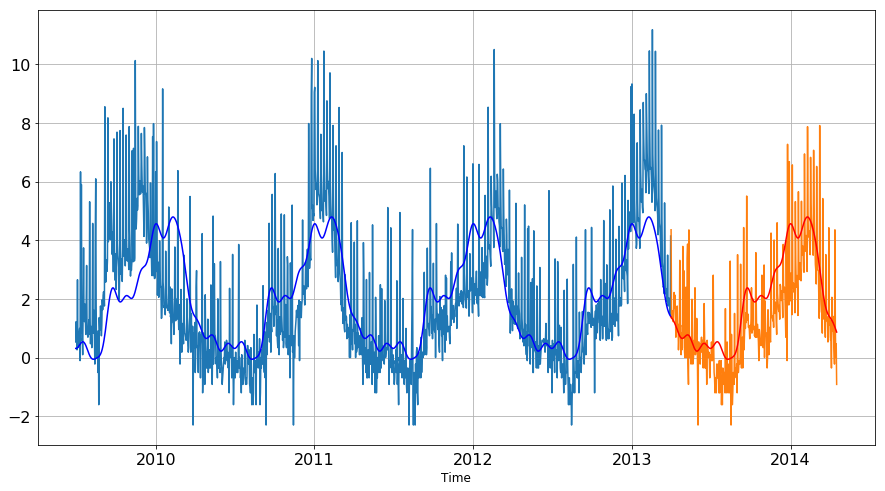

In [16]:
plt.plot(df.logbrut[df.index < '2013-04-01'])
plt.plot(df.logbrut[df.index >= '2013-04-01'])
plt.plot(df.index[df.index < '2013-04-01'], y_old_pred, 'b')
plt.plot(df.index[df.index >= '2013-04-01'], y_pred, 'r')
plt.xlabel('Time')
plt.grid()

Plot residuals of the prediction

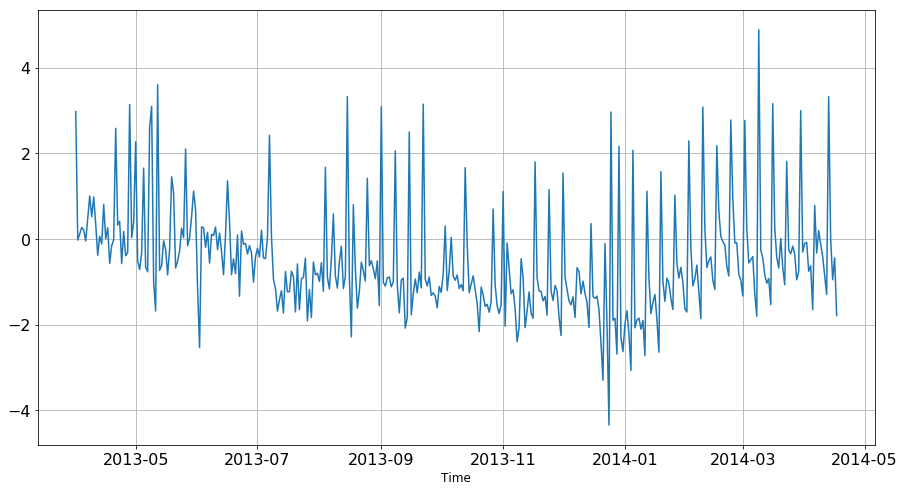

In [17]:
plt.plot(df.logbrut[df.index >= '2013-04-01'] - y_pred)
plt.xlabel('Time')
plt.grid()

Plot residuals after desesonalisaiton

## Data set "Internet traffic"

### 8. Load and plot data

Load the data

In [18]:
df = pd.read_csv('../data/lbl-tcp-3.tcp', delimiter=' ', decimal='.', 
                 names = ['time', 'info1', 'info2', 'info3', 'info4','info5'], 
                 skiprows = [0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789994 entries, 0 to 1789993
Data columns (total 6 columns):
time     float64
info1    int64
info2    int64
info3    int64
info4    int64
info5    int64
dtypes: float64(1), int64(5)
memory usage: 81.9 MB


,time,info1,info2,info3,info4,info5
0,0.010445,2,1,2436,23,2
1,0.023775,1,2,23,2436,2
2,0.026558,2,1,2436,23,1
3,0.029002,3,4,3930,119,42
4,0.032439,4,3,119,3930,15


Aggregate in 10 second interval counts

In [19]:
packages = pd.cut(df.time, bins = [x * 10 for x in list(range(721))])
packagesCount = packages.value_counts(sort = False)
np.array(packagesCount)
traffic = pd.Series(np.array(packagesCount), index = range(720))

Plot the data

Text(0.5,0,'Time (10 second intervals)')

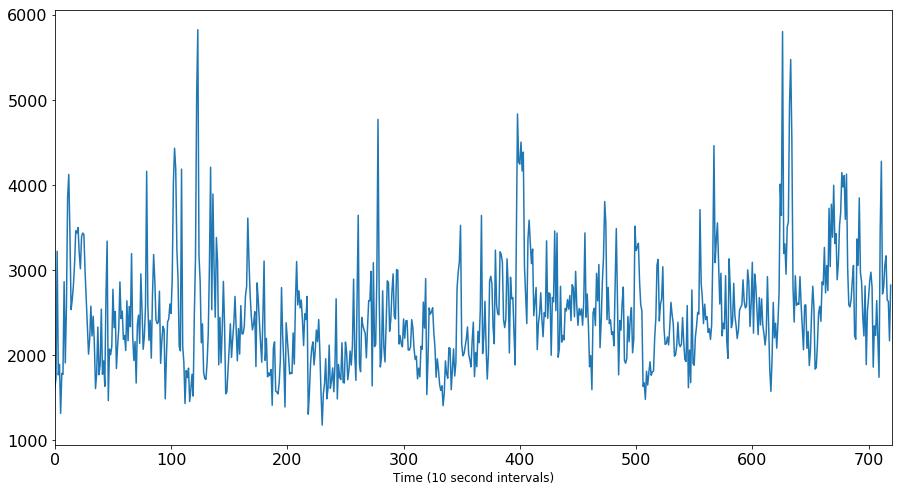

In [20]:
traffic.plot()
plt.xlim(0, 720)
plt.xlabel('Time (10 second intervals)')

### 9. Choose the AR model

Choose the model using AIC/BIC

In [21]:
ps = range(1,11)
for p in ps:
    model = ARIMA(traffic, order=(p,0,0))
    model_fit = model.fit()
    print('AR{} - AIC:{}; BIC:{}'.format(p, model_fit.aic, model_fit.bic))

AR1 - AIC:11043.490137252043; BIC:11057.227890888074
AR2 - AIC:11040.556460312504; BIC:11058.873465160545
AR3 - AIC:11041.373965545712; BIC:11064.270221605762
AR4 - AIC:11037.191783927336; BIC:11064.667291199396
AR5 - AIC:11039.054672463022; BIC:11071.109430947094
AR6 - AIC:11040.394132280087; BIC:11077.028141976169
AR7 - AIC:11042.280115373489; BIC:11083.49337628158
AR8 - AIC:11043.280525512118; BIC:11089.073037632219
AR9 - AIC:11045.274106075205; BIC:11095.645869407315
AR10 - AIC:11047.254828947487; BIC:11102.205843491609


Choose the model using CV

In [22]:
def ArimaCV(X, number_folds, order):
    k = int(np.floor(X.size) / number_folds)
    #print('Size of each fold: {}'.format(k))
    errors = np.zeros(number_folds - 1)
    for i in range(2, number_folds + 1):
        split = float(i - 1) / i
        #print('Splitting the first {} chunks at {}/{}'.format(str(i), str(i-1), str(i)))
        tsTrain = X[:(k * i)]
        #print('Size of train + test: {}'.format(X.shape))
        index = int(np.floor(X.size * split))
        # Folds used to train the model        
        tsTrainFolds = X[:index]
        # Fold used to test the model
        tsTestFold = X[index:]
        model = ARIMA(tsTrainFolds, order = order)
        model_fit = model.fit(disp = 0)
        prediction = model_fit.predict(start = index, end = index + tsTestFold.size)
        errors[i - 2] = ((tsTestFold - prediction)**2).mean()
        #print('Accuracy on fold {}: {}'.format(str(i), accuracies[i-2]))
    return errors.mean()

ps = range(1,11)
for p in ps:
    curError = ArimaCV(traffic, 10, (p,0,0))
    print('For p = {} the error is {}.'.format(p, curError))

For p = 1 the error is 608206.4770324425.
For p = 2 the error is 607732.3167164834.
For p = 3 the error is 607344.642868573.
For p = 4 the error is 605839.7487330358.
For p = 5 the error is 605891.6005281187.
For p = 6 the error is 605998.2408191853.
For p = 7 the error is 606666.5797815756.
For p = 8 the error is 606825.779959537.
For p = 9 the error is 606834.4140689289.
For p = 10 the error is 607562.7100428564.


### 10. Fit the AR model

In [23]:
pOptimal = 4
model = ARIMA(traffic, order=(pOptimal, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  720
Model:                     ARMA(4, 0)   Log Likelihood               -5512.596
Method:                       css-mle   S.D. of innovations            511.364
Date:                Sun, 12 Jan 2020   AIC                          11037.192
Time:                        20:00:57   BIC                          11064.667
Sample:                             0   HQIC                         11047.799
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2483.8256     61.200     40.585      0.000    2363.875    2603.776
ar.L1.y        0.5545      0.037     14.940      0.000       0.482       0.627
ar.L2.y        0.0545      0.043      1.280      0.2

Study residuals

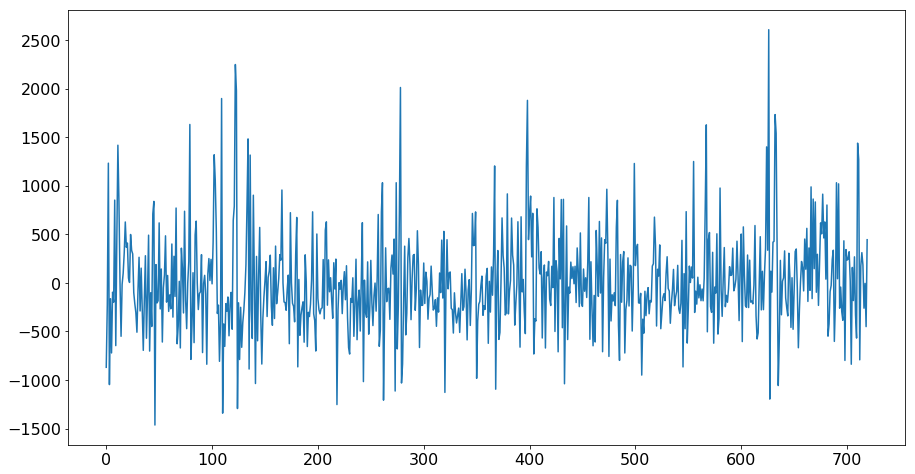

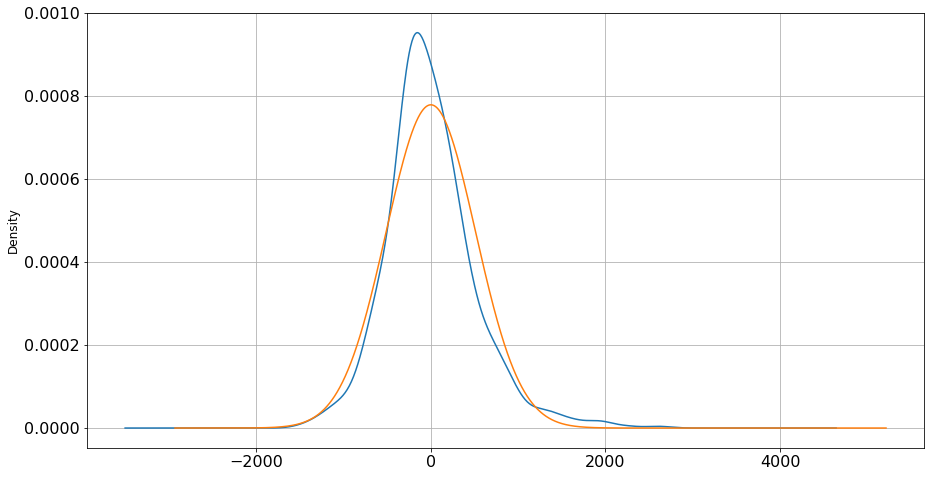

count     720.000000
mean        1.183954
std       512.149184
min     -1463.983815
25%      -290.102530
50%       -62.111938
75%       245.759437
max      2605.788351
dtype: float64


In [24]:
residuals = model_fit.resid
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.grid()
x = np.linspace(min(residuals) * 2, max(residuals) * 2, 5000)
mu = residuals.mean()
sigma = np.sqrt(residuals.var())
y_pdf = ss.norm.pdf(x, mu, sigma)
plt.plot(x, y_pdf)
plt.show()
print(residuals.describe())

## Data set "SOI"

### 11. Load and plot the data

In [25]:
df = pd.read_csv('../data/soi.tsv', delimiter='\t', decimal='.', squeeze=True, header=None)
df = df.T.dropna()
df.info()
soi = pd.Series(np.array(df[0]), index = range(df[0].size))
soi.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 1 columns):
0    780 non-null float64
dtypes: float64(1)
memory usage: 12.2 KB


0    1.537160
1    0.922168
2   -0.104204
3   -0.291903
4   -0.658745
dtype: float64

### 12. Plot ACF/PACF

ACF

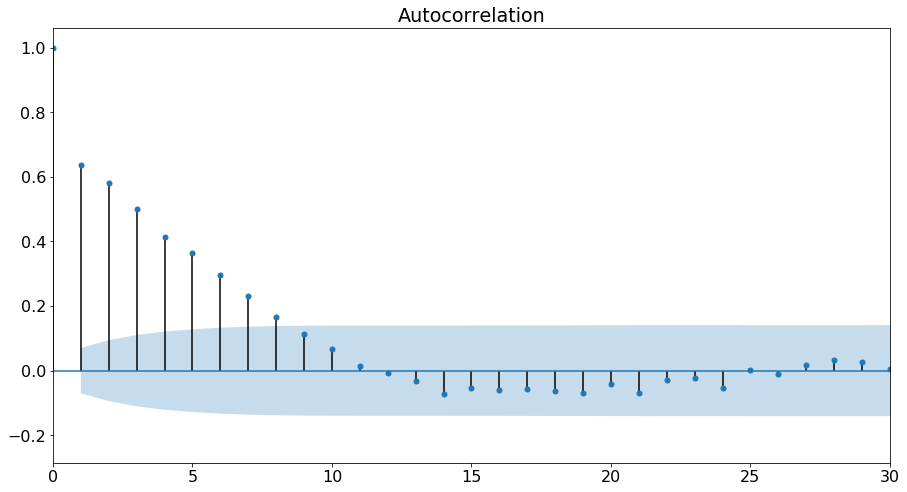

In [26]:
plot_acf(soi)
plt.xlim(0, 30)
plt.show()

PACF

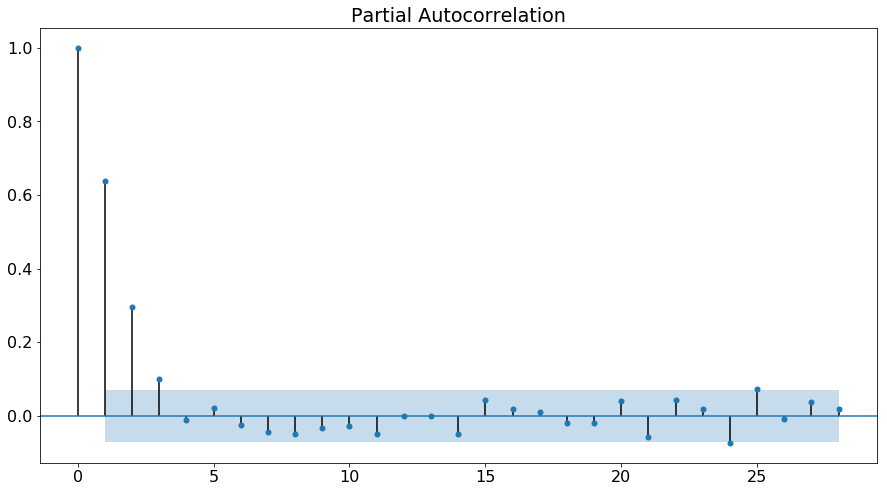

In [27]:
plot_pacf(soi, lags=10 * np.log10(len(soi)))
plt.show()

### 13. Fit the AR model and study its residuals

In [28]:
pOptimal = 4
model = ARIMA(soi, order=(pOptimal, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  780
Model:                     ARMA(4, 0)   Log Likelihood                -821.290
Method:                       css-mle   S.D. of innovations              0.693
Date:                Sun, 12 Jan 2020   AIC                           1654.579
Time:                        20:00:58   BIC                           1682.535
Sample:                             0   HQIC                          1665.331
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1288      0.106      1.214      0.225      -0.079       0.337
ar.L1.y        0.4226      0.036     11.793      0.000       0.352       0.493
ar.L2.y        0.2530      0.039      6.531      0.0

Study residuals

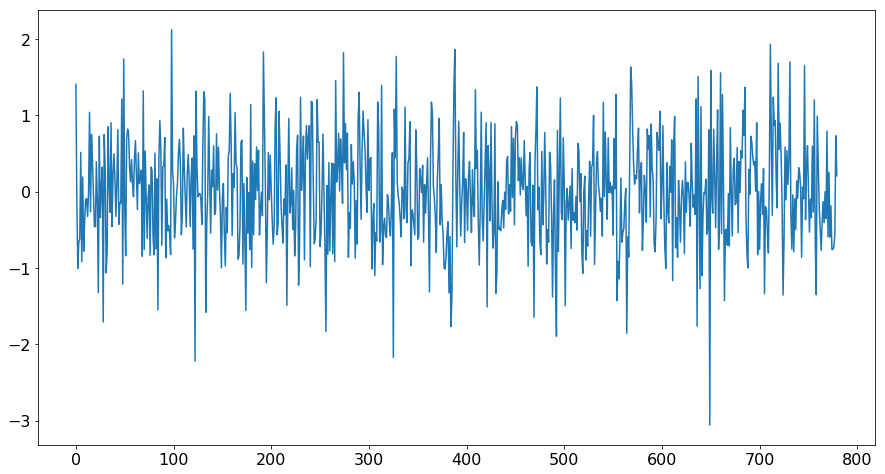

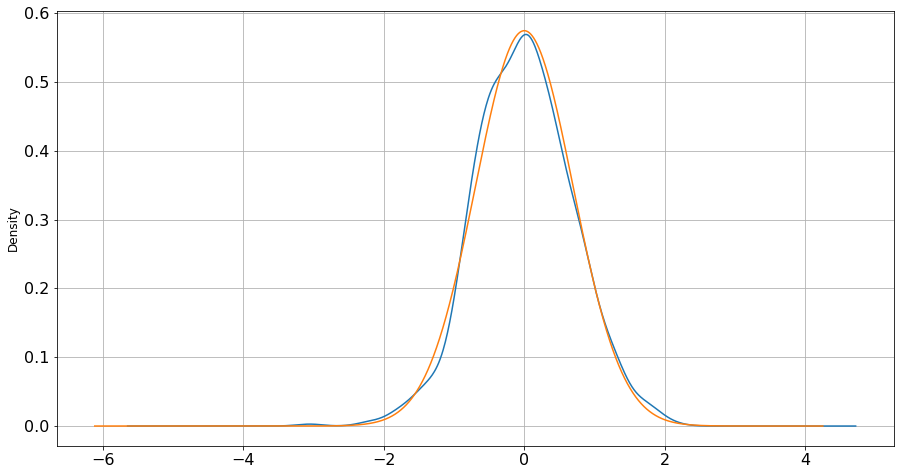

count    780.000000
mean      -0.002198
std        0.694478
min       -3.058077
25%       -0.479530
50%       -0.007303
75%        0.442304
max        2.123565
dtype: float64


In [29]:
residuals = model_fit.resid
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.grid()
x = np.linspace(min(residuals) * 2, max(residuals) * 2, 5000)
mu = residuals.mean()
sigma = np.sqrt(residuals.var())
y_pdf = ss.norm.pdf(x, mu, sigma)
plt.plot(x, y_pdf)
plt.show()
print(residuals.describe())

### 14. Plot the spectrogram

/Users/pavlo.mozharovskyi/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


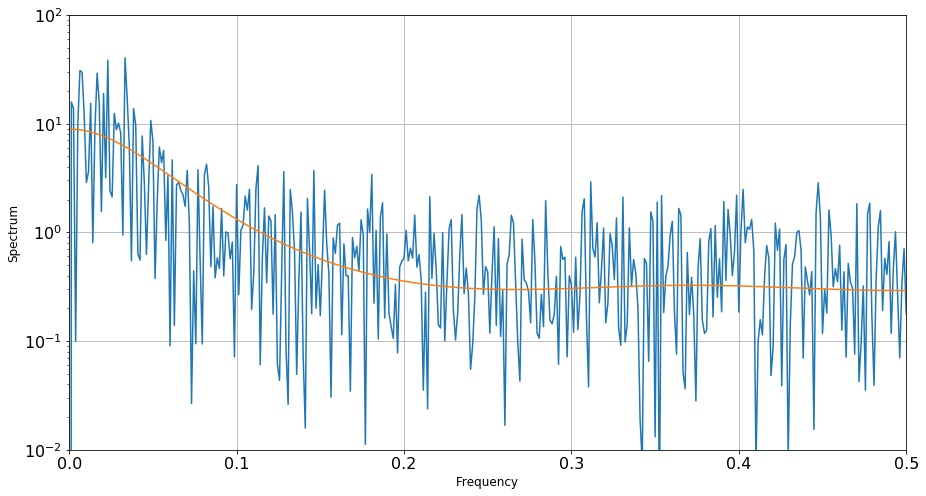

In [30]:
# Plot the spectrum of the data
f, Pxx_den = signal.periodogram(soi)
plt.semilogy(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-2, 1e+2])
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
# Plot the spectrum of the AR process
w = np.array(range(501)) / 1000
fs = np.ones(501)
for i in range(501):
    for j in range(1,len(model_fit.params)):
        z_tmp = complex(0, 2 * np.pi * j * w[i])
        fs[i] = fs[i] - model_fit.params[j] * np.exp(-z_tmp)
    fs[i] = model_fit.sigma2 / fs[i] ** 2
plt.plot(w, fs)
plt.show()